In [12]:
import pandas as pd
import numpy as np
from utils.utils import load_all_games_csv, get_teams
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Rest Days Analysis
This notebook will examine the relationship between rest days and the probability of a given team winning.

## Get all Games

In [2]:
all_games = load_all_games_csv('../data/gameinfo_cleaned.csv')

/Users/lancehendricks/Documents/College Coding/ML/Elo Ratings/src/utils/utils.py:18: DtypeWarning: Columns (10,11,13,17,19,21,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  all_games = pd.read_csv(filename)


## Win % vs Rest days

In [21]:
# Get rest day groupings - home
home_rest_days = all_games.groupby(by='homerestdays').agg({'homewon':'sum', 'hometeam':'count'}).rename(columns={'homewon':'Wins', 'hometeam':'Games'})
home_rest_days.index = home_rest_days.index.rename('Rest Days')

# Get rest day groupings - away
away_rest_days = all_games.groupby(by='visrestdays').agg({'homewon':lambda x:(1-x).sum(), 'hometeam':'count'}).rename(columns={'homewon':'AwayWins', 'hometeam':'AwayGames'})
away_rest_days.index = away_rest_days.index.rename('Rest Days')

rest_days = home_rest_days.join(away_rest_days, how='outer')
rest_days['Wins'] = rest_days['Wins'].fillna(0) + rest_days['AwayWins'].fillna(0)
rest_days['Games'] = rest_days['Games'].fillna(0) + rest_days['AwayGames'].fillna(0)

rest_days = rest_days.drop(['AwayWins', 'AwayGames'], axis=1)
rest_days['Win %'] = rest_days['Wins'] / rest_days['Games']
rest_days.head()

,Wins,Games,Win %
Rest Days,,,
0.0,17224.0,34443.0,0.500073
1.0,164996.0,330074.0,0.499876
2.0,28069.0,55989.0,0.501331
3.0,3849.0,7705.0,0.499546
4.0,1720.0,3476.0,0.494822


Text(0.5, 1.0, 'Win % vs Rest Days')

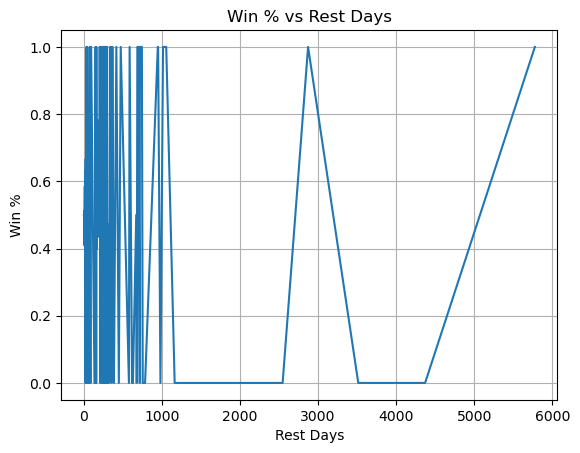

In [22]:
# Only look at a week
#rest_days = rest_days.loc[:10]

plt.plot(rest_days.index, rest_days['Win %'])
plt.grid()
plt.xlabel("Rest Days")
plt.ylabel("Win %")
plt.title("Win % vs Rest Days")

### Find possible max rest days to best predict wins

In [23]:
train_df = all_games.sample(frac=0.8)
test_df = all_games[~all_games.index.isin(train_df.index)]

In [24]:
# Get X train/test and y train/test
Xs = []
ys = []
for df in [train_df, test_df]:
    # Get rest day groupings - home
    home_rest_days = df.groupby(by='homerestdays').agg({'homewon':'sum', 'hometeam':'count'}).rename(columns={'homewon':'Wins', 'hometeam':'Games'})
    home_rest_days.index = home_rest_days.index.rename('Rest Days')

    # Get rest day groupings - away
    away_rest_days = df.groupby(by='visrestdays').agg({'homewon':lambda x:(1-x).sum(), 'hometeam':'count'}).rename(columns={'homewon':'AwayWins', 'hometeam':'AwayGames'})
    away_rest_days.index = away_rest_days.index.rename('Rest Days')

    rest_days = home_rest_days.join(away_rest_days, how='outer')
    rest_days['Wins'] = rest_days['Wins'].fillna(0) + rest_days['AwayWins'].fillna(0)
    rest_days['Games'] = rest_days['Games'].fillna(0) + rest_days['AwayGames'].fillna(0)

    rest_days = rest_days.drop(['AwayWins', 'AwayGames'], axis=1)
    rest_days['Win %'] = rest_days['Wins'] / rest_days['Games']
    
    X = rest_days.index.to_numpy().reshape(-1,1) 
    y = rest_days['Win %'].to_numpy().reshape(-1,1)
    
    Xs.append(X)
    ys.append(y)
    
X_train = Xs[0]
X_test = Xs[1]
y_train = ys[0]
y_test = ys[1]

Text(0.5, 1.0, 'Test MSE vs Max Rest Days')

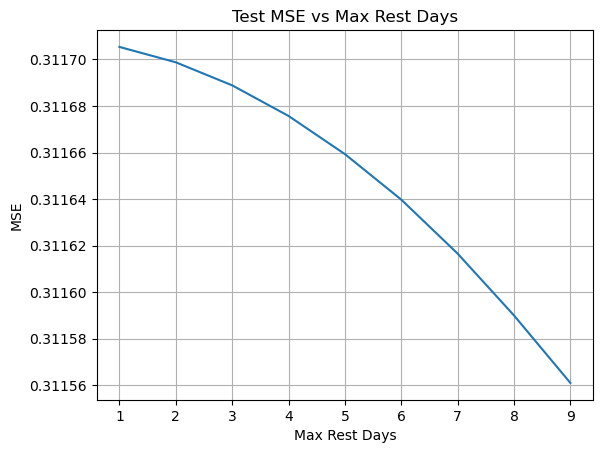

In [26]:
max_vals = list(range(1,10,1))
mses = []

for max_val in max_vals:
    X_train_vals = np.full_like(X_train, max_val)
    X_test_vals = np.full_like(X_test, max_val)
    
    X_train_maxed = np.max(np.hstack((X_train, X_train_vals)), axis=1).reshape(-1,1)
    X_test_maxed = np.max(np.hstack((X_test, X_test_vals)), axis=1).reshape(-1,1)
    
    lr = LinearRegression(fit_intercept=False)
    
    lr.fit(X_train_maxed,y_train)
    
    y_hat = lr.predict(X_test_maxed)
    mse = mean_squared_error(y_test, y_hat)
    mses.append(mse)
    
plt.plot(max_vals, mses)
plt.grid()
plt.xlabel("Max Rest Days")
plt.ylabel("MSE")
plt.title("Test MSE vs Max Rest Days")
    